In [1]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
import pytz
from numba import njit

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import base_optimizer

import vectorbt as vbt
from vectorbt.generic.nb import nanmean_nb
from vectorbt.portfolio.nb import order_nb, sort_call_seq_nb
from vectorbt.portfolio.enums import SizeType, Direction

C:\Users\npc94\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\npc94\anaconda3\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
C:\Users\npc94\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\npc94\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
symbols = ['IVW','IVE','IWN','IWO','EFA','EEM','IEF','TLT','IAU']
start_date = datetime(2010, 1, 1, tzinfo=pytz.utc)

num_tests = 2000

vbt.settings.array_wrapper['freq'] = 'days'
vbt.settings.returns['year_freq'] = '252 days'
vbt.settings.portfolio['seed'] = 42
vbt.settings.portfolio.stats['incl_unrealized'] = True

In [3]:
yfdata = vbt.YFData.download(symbols, start=start_date)

print(yfdata.symbols)

['IVW', 'IVE', 'IWN', 'IWO', 'EFA', 'EEM', 'IEF', 'TLT', 'IAU']


In [4]:
ohlcv = yfdata.concat()

print(ohlcv.keys())

dict_keys(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'])


In [5]:
price = ohlcv['Close']

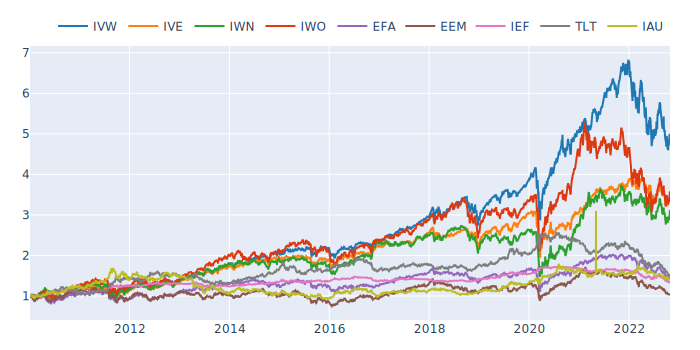

In [6]:
# Plot normalized price series
(price / price.iloc[0]).vbt.plot().show_svg()

In [7]:
returns = price.pct_change()

In [8]:
print(returns.mean())

symbol
IVW    0.000565
IVE    0.000457
IWN    0.000455
IWO    0.000504
EFA    0.000207
EEM    0.000109
IEF    0.000104
TLT    0.000171
IAU    0.000311
dtype: float64


In [9]:
print(returns.std())

symbol
IVW    0.011817
IVE    0.011053
IWN    0.014287
IWO    0.014764
EFA    0.012048
EEM    0.014042
IEF    0.004018
TLT    0.009441
IAU    0.022088
dtype: float64


In [10]:
print(returns.corr())

symbol       IVW       IVE       IWN       IWO       EFA       EEM       IEF  \
symbol                                                                         
IVW     1.000000  0.876503  0.790006  0.872309  0.826821  0.771818 -0.300187   
IVE     0.876503  1.000000  0.904353  0.841666  0.873787  0.777218 -0.392569   
IWN     0.790006  0.904353  1.000000  0.915336  0.805581  0.722377 -0.351132   
IWO     0.872309  0.841666  0.915336  1.000000  0.794406  0.740656 -0.308196   
EFA     0.826821  0.873787  0.805581  0.794406  1.000000  0.859328 -0.345911   
EEM     0.771818  0.777218  0.722377  0.740656  0.859328  1.000000 -0.291951   
IEF    -0.300187 -0.392569 -0.351132 -0.308196 -0.345911 -0.291951  1.000000   
TLT    -0.338519 -0.440299 -0.392078 -0.341357 -0.392220 -0.329414  0.916413   
IAU     0.011639  0.007904  0.013606  0.014281  0.058486  0.064577  0.127571   

symbol       TLT       IAU  
symbol                      
IVW    -0.338519  0.011639  
IVE    -0.440299  0.007904  
IWN

In [11]:
np.random.seed(42)

# Generate random weights, n times
weights = []
for i in range(num_tests):
    w = np.random.random_sample(len(symbols))
    w = w / np.sum(w)
    weights.append(w)

print(len(weights))

2000


In [12]:
# Build column hierarchy such that one weight corresponds to one price series
_price = price.vbt.tile(num_tests, keys=pd.Index(np.arange(num_tests), name='symbol_group'))
_price = _price.vbt.stack_index(pd.Index(np.concatenate(weights), name='weights'))

print(_price.columns)

MultiIndex([( 0.08335534102285165,    0, 'IVW'),
            ( 0.21158511795741236,    0, 'IVE'),
            ( 0.16290806131563432,    0, 'IWN'),
            ( 0.13323374345060188,    0, 'IWO'),
            ( 0.03472254726682813,    0, 'EFA'),
            ( 0.03471717924460712,    0, 'EEM'),
            ( 0.01292673082664457,    0, 'IEF'),
            ( 0.19277082583068503,    0, 'TLT'),
            (   0.133780453084735,    0, 'IAU'),
            (  0.1798244475819697,    1, 'IVW'),
            ...
            ( 0.06623801341099832, 1998, 'IAU'),
            (  0.1505747196861699, 1999, 'IVW'),
            (0.003168437511772816, 1999, 'IVE'),
            ( 0.09426964879750889, 1999, 'IWN'),
            (  0.1258348217498007, 1999, 'IWO'),
            ( 0.10751358874137083, 1999, 'EFA'),
            ( 0.13148950104413445, 1999, 'EEM'),
            ( 0.12546590251084744, 1999, 'IEF'),
            ( 0.11964617745457802, 1999, 'TLT'),
            ( 0.14203720250381688, 1999, 'IAU')],
   

In [13]:
# Define order size
size = np.full_like(_price, np.nan)
size[0, :] = np.concatenate(weights)  # allocate at first timestamp, do nothing afterwards

print(size.shape)

(3229, 18000)


In [14]:
# Run simulation
pf = vbt.Portfolio.from_orders(
    close=_price,
    size=size,
    size_type='targetpercent',
    group_by='symbol_group',
    cash_sharing=True
) # all weights sum to 1, no shorting, and 100% investment in risky assets

print(len(pf.orders))

18000


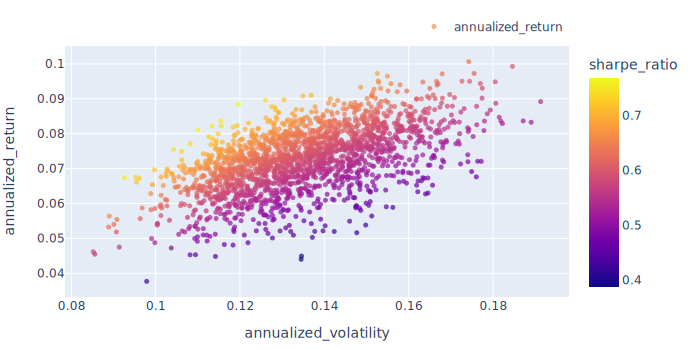

In [15]:
# Plot annualized return against volatility, color by sharpe ratio
annualized_return = pf.annualized_return()
annualized_return.index = pf.annualized_volatility()
annualized_return.vbt.scatterplot(
    trace_kwargs=dict(
        mode='markers', 
        marker=dict(
            color=pf.sharpe_ratio(),
            colorbar=dict(
                title='sharpe_ratio'
            ),
            size=5,
            opacity=0.7
        )
    ),
    xaxis_title='annualized_volatility',
    yaxis_title='annualized_return'
).show_svg()

In [16]:
# Get index of the best group according to the target metric
best_symbol_group = pf.sharpe_ratio().idxmax()

print(best_symbol_group)

317


In [17]:
print(weights[best_symbol_group])

[0.29184977 0.03235691 0.16081182 0.07019505 0.01237336 0.01144809
 0.05569185 0.27549114 0.08978202]


In [18]:
print(pf.iloc[best_symbol_group].stats())

Start                         2010-01-04 00:00:00+00:00
End                           2022-10-28 00:00:00+00:00
Period                               3229 days 00:00:00
Start Value                                       100.0
End Value                                    296.153846
Total Return [%]                             196.153846
Benchmark Return [%]                         145.507272
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                               28.96062
Max Drawdown Duration                 301 days 00:00:00
Total Trades                                          9
Total Closed Trades                                   0
Total Open Trades                                     9
Open Trade PnL                               196.153846
Win Rate [%]                                        NaN
Best Trade [%]                                      NaN
Worst Trade [%]                                 

## 每月再平衡

In [19]:
rb_mask = ~_price.index.to_period('m').duplicated()

print(rb_mask.sum())

154


C:\Users\npc94\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1162: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



In [20]:
rb_size = np.full_like(_price, np.nan)
rb_size[rb_mask, :] = np.concatenate(weights)  # allocate at mask

print(rb_size.shape)

(3229, 18000)


In [21]:
# Run simulation, with rebalancing monthly
rb_pf = vbt.Portfolio.from_orders(
    close=_price,
    size=rb_size,
    size_type='targetpercent',
    group_by='symbol_group',
    cash_sharing=True,
    call_seq='auto'  # important: sell before buy
)

print(len(rb_pf.orders))

2771984


In [22]:
rb_best_symbol_group = rb_pf.sharpe_ratio().idxmax()

print(rb_best_symbol_group)

1593


In [23]:
print(weights[rb_best_symbol_group])

[0.22217529 0.08379233 0.10295035 0.0730191  0.04114347 0.03220717
 0.21261051 0.22199867 0.0101031 ]


In [24]:
print(rb_pf.iloc[rb_best_symbol_group].stats())

Start                            2010-01-04 00:00:00+00:00
End                              2022-10-28 00:00:00+00:00
Period                                  3229 days 00:00:00
Start Value                                          100.0
End Value                                       261.924245
Total Return [%]                                161.924245
Benchmark Return [%]                            145.507272
Max Gross Exposure [%]                               100.0
Total Fees Paid                                        0.0
Max Drawdown [%]                                 26.197956
Max Drawdown Duration                    254 days 00:00:00
Total Trades                                           700
Total Closed Trades                                    691
Total Open Trades                                        9
Open Trade PnL                                   33.081158
Win Rate [%]                                      94.06657
Best Trade [%]                                  215.8667

In [25]:
def plot_allocation(rb_pf):
    # Plot weights development of the portfolio
    rb_asset_value = rb_pf.asset_value(group_by=False)
    rb_value = rb_pf.value()
    rb_idxs = np.flatnonzero((rb_pf.asset_flow() != 0).any(axis=1))
    rb_dates = rb_pf.wrapper.index[rb_idxs]
    fig = (rb_asset_value.vbt / rb_value).vbt.plot(
        trace_names=symbols,
        trace_kwargs=dict(
            stackgroup='one'
        )
    )
    for rb_date in rb_dates:
        fig.add_shape(
            dict(
                xref='x',
                yref='paper',
                x0=rb_date,
                x1=rb_date,
                y0=0,
                y1=1,
                line_color=fig.layout.template.layout.plot_bgcolor
            )
        )
    fig.show_svg()

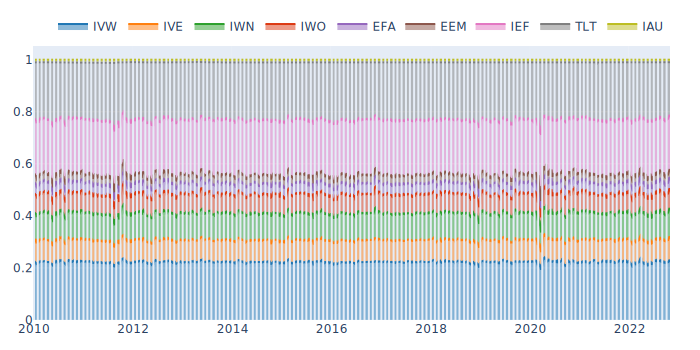

In [26]:
plot_allocation(rb_pf.iloc[rb_best_symbol_group])  # best group

In [27]:
srb_sharpe = np.full(price.shape[0], np.nan)

@njit
def pre_sim_func_nb(c, every_nth):
    # Define rebalancing days
    c.segment_mask[:, :] = False
    c.segment_mask[every_nth::every_nth, :] = True
    return ()

@njit
def find_weights_nb(c, price, num_tests):
    # Find optimal weights based on best Sharpe ratio
    returns = (price[1:] - price[:-1]) / price[:-1]
    returns = returns[1:, :]  # cannot compute np.cov with NaN
    mean = nanmean_nb(returns)
    cov = np.cov(returns, rowvar=False)  # masked arrays not supported by Numba (yet)
    best_sharpe_ratio = -np.inf
    weights = np.full(c.group_len, np.nan, dtype=np.float_)
    
    for i in range(num_tests):
        # Generate weights
        w = np.random.random_sample(c.group_len)
        w = w / np.sum(w)
        
        # Compute annualized mean, covariance, and Sharpe ratio
        p_return = np.sum(mean * w) * ann_factor
        p_std = np.sqrt(np.dot(w.T, np.dot(cov, w))) * np.sqrt(ann_factor)
        sharpe_ratio = p_return / p_std
        if sharpe_ratio > best_sharpe_ratio:
            best_sharpe_ratio = sharpe_ratio
            weights = w
            
    return best_sharpe_ratio, weights

@njit
def pre_segment_func_nb(c, find_weights_nb, history_len, ann_factor, num_tests, srb_sharpe):
    if history_len == -1:
        # Look back at the entire time period
        close = c.close[:c.i, c.from_col:c.to_col]
    else:
        # Look back at a fixed time period
        if c.i - history_len <= 0:
            return (np.full(c.group_len, np.nan),)  # insufficient data
        close = c.close[c.i - history_len:c.i, c.from_col:c.to_col]

    # Find optimal weights
    best_sharpe_ratio, weights = find_weights_nb(c, close, num_tests)
    srb_sharpe[c.i] = best_sharpe_ratio

    # Update valuation price and reorder orders
    size_type = SizeType.TargetPercent
    direction = Direction.LongOnly
    order_value_out = np.empty(c.group_len, dtype=np.float_)
    for k in range(c.group_len):
        col = c.from_col + k
        c.last_val_price[col] = c.close[c.i, col]
    sort_call_seq_nb(c, weights, size_type, direction, order_value_out)

    return (weights,)

@njit
def order_func_nb(c, weights):
    col_i = c.call_seq_now[c.call_idx]
    return order_nb(
        weights[col_i], 
        c.close[c.i, c.col],
        size_type=SizeType.TargetPercent
    )

In [28]:
ann_factor = returns.vbt.returns.ann_factor

In [29]:
# Run simulation using a custom order function
srb_pf = vbt.Portfolio.from_order_func(
    price,
    order_func_nb,
    pre_sim_func_nb=pre_sim_func_nb,
    pre_sim_args=(30,),
    pre_segment_func_nb=pre_segment_func_nb,
    pre_segment_args=(find_weights_nb, -1, ann_factor, num_tests, srb_sharpe),
    cash_sharing=True, 
    group_by=True
)

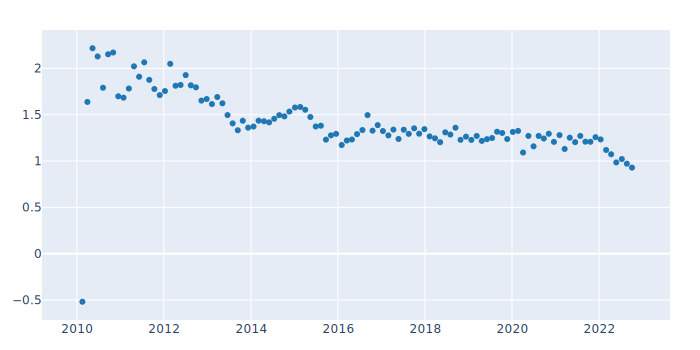

In [30]:
# Plot best Sharpe ratio at each rebalancing day
pd.Series(srb_sharpe, index=price.index).vbt.scatterplot(trace_kwargs=dict(mode='markers')).show_svg()

In [31]:
print(srb_pf.stats())

Start                         2010-01-04 00:00:00+00:00
End                           2022-10-28 00:00:00+00:00
Period                               3229 days 00:00:00
Start Value                                       100.0
End Value                                    211.279459
Total Return [%]                             111.279459
Benchmark Return [%]                         145.507272
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                              32.716078
Max Drawdown Duration                 375 days 00:00:00
Total Trades                                        478
Total Closed Trades                                 469
Total Open Trades                                     9
Open Trade PnL                               -20.553019
Win Rate [%]                                  69.083156
Best Trade [%]                                42.570549
Worst Trade [%]                              -25

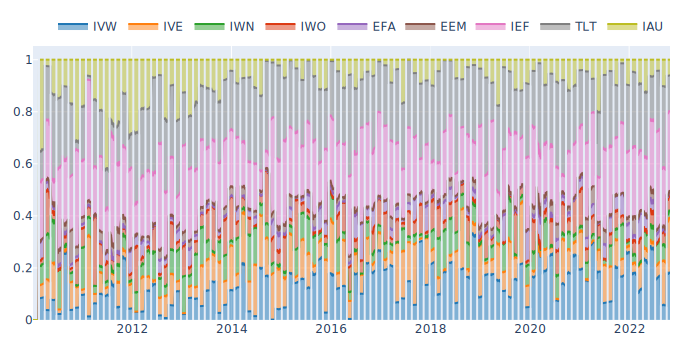

In [32]:
plot_allocation(srb_pf)

In [33]:
# Run simulation, but now consider only the last 252 days of data
srb252_sharpe = np.full(price.shape[0], np.nan)

srb252_pf = vbt.Portfolio.from_order_func(
    price,
    order_func_nb,
    pre_sim_func_nb=pre_sim_func_nb,
    pre_sim_args=(30,),
    pre_segment_func_nb=pre_segment_func_nb,
    pre_segment_args=(find_weights_nb, 252, ann_factor, num_tests, srb252_sharpe),
    cash_sharing=True, 
    group_by=True
)

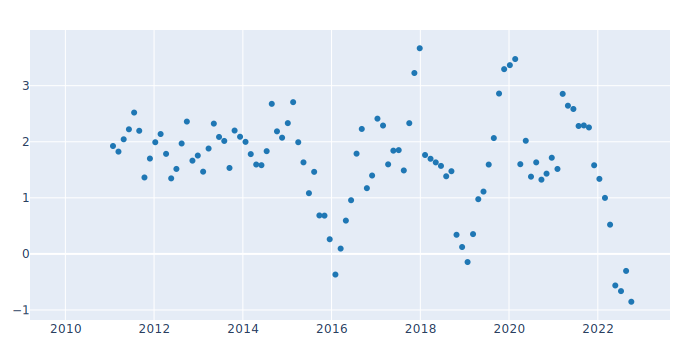

In [34]:
pd.Series(srb252_sharpe, index=price.index).vbt.scatterplot(trace_kwargs=dict(mode='markers')).show_svg()

In [35]:
print(srb252_pf.stats())

Start                            2010-01-04 00:00:00+00:00
End                              2022-10-28 00:00:00+00:00
Period                                  3229 days 00:00:00
Start Value                                          100.0
End Value                                       189.349956
Total Return [%]                                 89.349956
Benchmark Return [%]                            145.507272
Max Gross Exposure [%]                               100.0
Total Fees Paid                                        0.0
Max Drawdown [%]                                 25.992658
Max Drawdown Duration                    375 days 00:00:00
Total Trades                                           446
Total Closed Trades                                    437
Total Open Trades                                        9
Open Trade PnL                                   -6.235665
Win Rate [%]                                     66.132723
Best Trade [%]                                   42.9260

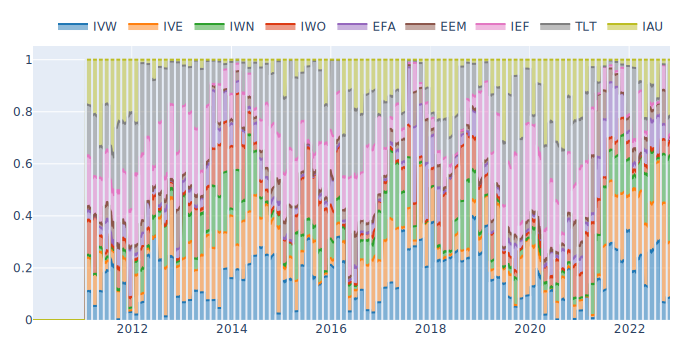

In [36]:
plot_allocation(srb252_pf)